# Clipping Approaches  in  Python  with RioXarray

Clipping can be affected by:
* Using the inbuilt rxr `crs=` parameter vs. transformed the `crs` with gpd
* The `all_touched` parameter

## Getting set up with libraries and the Cold Springs Fire data

In [2]:
from glob import glob
import os
import warnings

import matplotlib.pyplot as plt
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import box, Polygon, mapping
import rasterio as rio
import earthpy as et

et.data.get_data('cs-test-naip')
et.data.get_data('cold-springs-fire')
et.data.get_data('cold-springs-modis-h4')
et.data.get_data(url="https://ndownloader.figshare.com/files/21941085")

os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))
warnings.simplefilter('ignore')

rioxarray_option = rxr.set_options(export_grid_mapping=False)

In [3]:
# Open fire boundary
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")
fire_boundary = gpd.read_file(fire_boundary_path)

## Open and Clip Landsat Data


In [4]:
data_path = os.path.join("earthpy-downloads",
                         "landsat-coldsprings-hw")

# Open a  single file
all_files = sorted(glob(os.path.join(data_path,
                                     "LC080340322016062101T1-SC20200306230017",
                                     "*band[3-7]*.tif")))
band_path = all_files[0]
band_path

'earthpy-downloads/landsat-coldsprings-hw/LC080340322016062101T1-SC20200306230017/LC08_L1TP_034032_20160621_20170221_01_T1_sr_band3.tif'

In [5]:
# reproject fire boundary to utmz

with rio.open(band_path) as src:
    landsat_crs = src.crs

crop_bound_box = [box(*fire_boundary.total_bounds)]

fire_boundary_utmz13 = fire_boundary.to_crs(landsat_crs)

crop_bound_utmz13_box = [box(*fire_boundary_utmz13.total_bounds)]

landsat_box = gpd.GeoDataFrame(
    geometry=crop_bound_utmz13_box)

In [6]:
# This is how rioxarray is projecting the data when you use crs=
# The reprojection is actually slightly different vs how Geopandas does it
landsat_transform = rio.warp.transform_geom(
    fire_boundary.crs, landsat_crs, crop_bound_box)
landsat_transformed_bounds = gpd.GeoDataFrame(geometry=[Polygon(
    landsat_transform[0]['coordinates'][0][::1])], crs=landsat_crs)

In [12]:
fire_boundary.crs, landsat_crs # modis_crs

(<Geographic 2D CRS: EPSG:4269>
 Name: NAD83
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin 

In [13]:
# Plotting function

def plot_with_boundaries(boundary, bbox, raster):
    """
    Plot a raster and its clipping boundary
    
    Parameters
    ----------
      boundary : gpd.GeoDataFrame
        The boundary to plot
        
      bbox : gpd.GeoDataFrame
        The bounds used to clip
        
      raster : xr.Dataset
        The data to plot
      
      
    Returns
    -------
      boundary_plot : a matplotlib figure
    """
    # Plot the Data
    f,  ax = plt.subplots(figsize=(14, 5))
    raster.plot(
        ax=ax,
        add_colorbar=False)

    boundary.plot(
        ax=ax,
        edgecolor="yellow",
        facecolor="none",
        linewidth=2)

    bbox.plot(
        ax=ax,
        edgecolor="red",
        facecolor="none",
        linewidth=1)
    
    return ax
    

### Landsat Case 1
`crs=...`
`all_touched=True`

[Text(0.5, 1.0, 'All Touched =  True White Edge on the left - Notice the Clip extent is slightly skewed Causing This')]

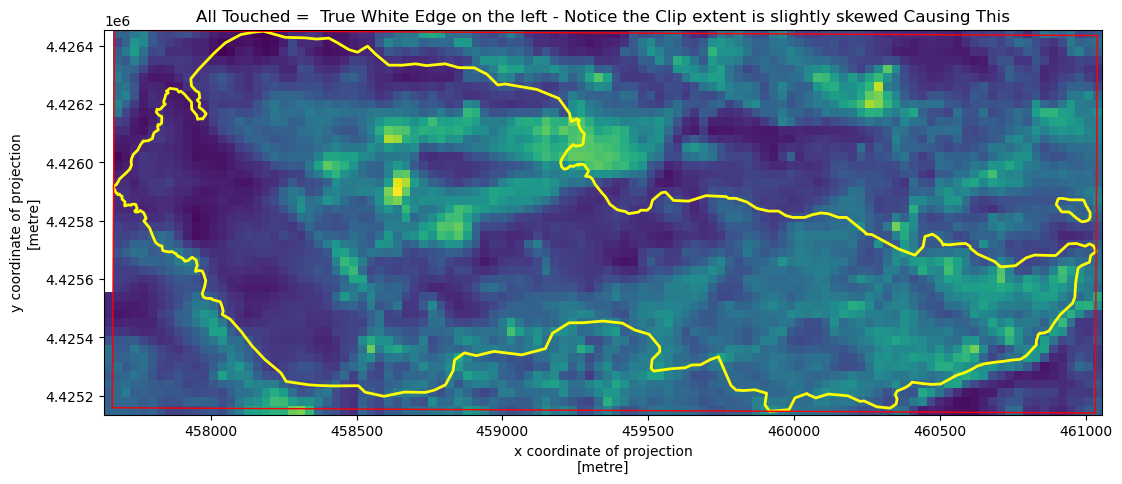

In [14]:
band = (
    rxr.open_rasterio(
        band_path,  
        masked=True)
    .rio.clip(
        crop_bound_box,
        crs=fire_boundary.crs,
        all_touched=True,
        from_disk=True)
    .squeeze()
)

ax = plot_with_boundaries(
    fire_boundary_utmz13, landsat_transformed_bounds, band)
ax.set(title=("All Touched =  True White Edge on the left - "
              "Notice the Clip extent is slightly skewed Causing This"))

### Landsat Case 2
`crs=...`
`all_touched=False`

[Text(0.5, 1.0, 'All_touched = False, White Edge on the top and right as well')]

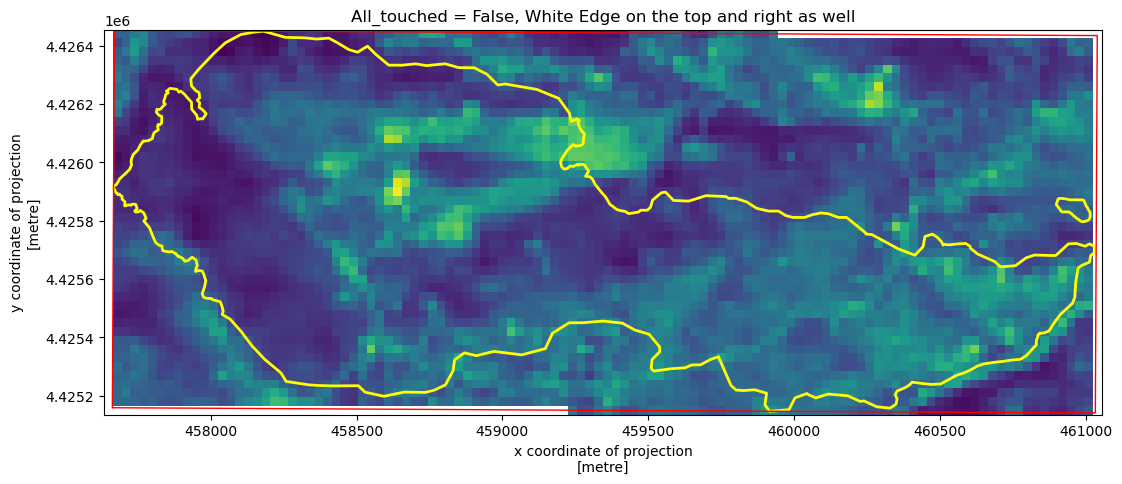

In [15]:
band = (
    rxr.open_rasterio(
        band_path,
        masked=True)
    .rio.clip(
        crop_bound_box,
        crs=fire_boundary.crs,
        all_touched=False, 
        from_disk=True)
    .squeeze()
)

# Plot the data
ax = plot_with_boundaries(
    fire_boundary_utmz13, landsat_transformed_bounds, band)
ax.set(title="All_touched = False, White Edge on the top and right as well")

It appears as if the white edges are  artifacts of how the data are reprojected 
above. It thus might be better practice to reproject first.  

### Landsat Case 3
**not** `crs=...`
`all_touched=True`

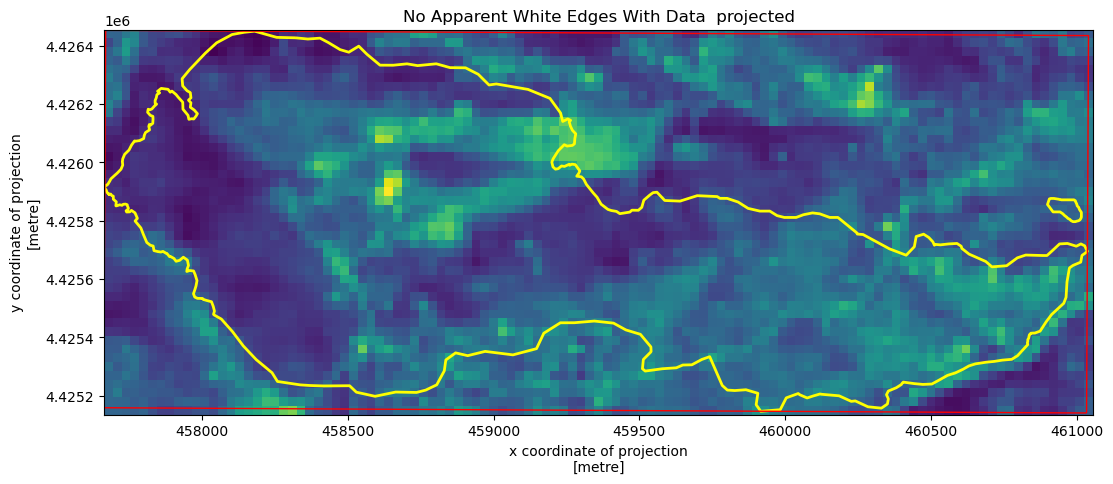

In [16]:
band = (
    rxr.open_rasterio(
        band_path,
        masked=True)
    .rio.clip(
        crop_bound_utmz13_box,
        all_touched=True,
        from_disk=True)
    .squeeze()
)

# Plot the data
ax = plot_with_boundaries(
    fire_boundary_utmz13, landsat_transformed_bounds, band)

ax.set(title="No Apparent White Edges With Data  projected")
plt.show()

### Landsat Case 4
**not** `crs=...`
`all_touched=False`

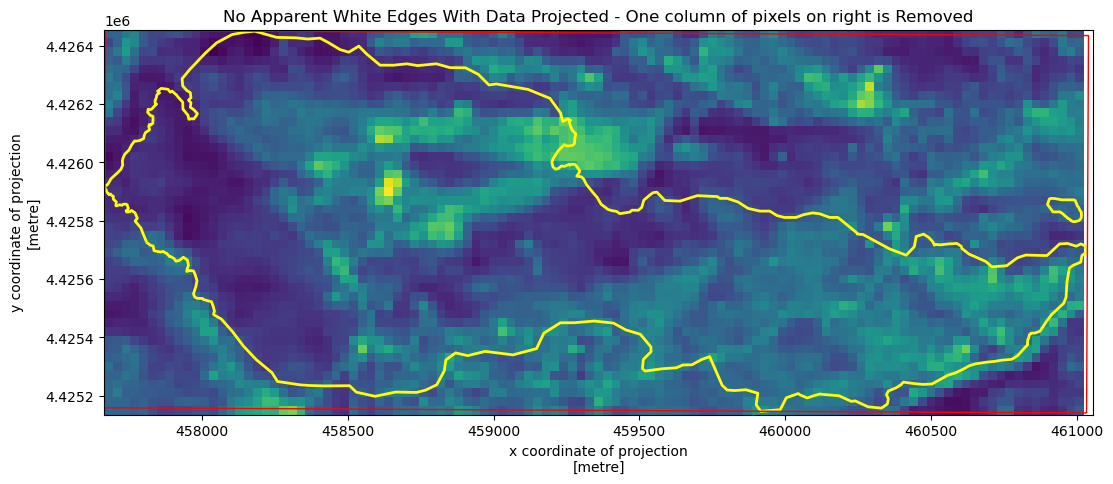

In [17]:
band = (
    rxr.open_rasterio(
        band_path,
        masked=True)
    .rio.clip(
        crop_bound_utmz13_box,
        all_touched=False,
        from_disk=True)
    .squeeze()
)

# Plot the data
ax = plot_with_boundaries(
    fire_boundary_utmz13, landsat_transformed_bounds, band)

ax.set(title="No Apparent White Edges With Data Projected - One column of pixels on right is Removed")
plt.show()

### Conclusions  -  Landsat  Data  Processing

It is clearly cleaner (less artifacts) to NOT use `crs=` and to 
reproject the fire boundary first. The reproject  process in rioxarray
seems to modify the data in a way that is undesirable causing edge artifacts



##  Open and clip MODIS Data

In [18]:
modis_h4_path = glob(os.path.join(
    "cold-springs-modis-h4", "17_july_2016", "*.hdf"))[0]

desired_bands = ["sur_refl_b01_1"]
modis_h4_path

'cold-springs-modis-h4/17_july_2016/MOD09GA.A2016199.h09v05.006.2016201065406.hdf'

In [19]:
# reproject fire boundary to sinusoidal
with rio.open(modis_h4_path) as src:
    for data in src.subdatasets:
        with rio.open(data) as data_src: 
            modis_crs = data_src.crs

fire_boundary_modis = fire_boundary.to_crs(modis_crs)

fire_box = [box(*fire_boundary.total_bounds)]

modis_box = gpd.GeoDataFrame(geometry=[box(*fire_boundary_modis.total_bounds)])

# This is how rioxarray is projecting the data when you use crs=
# The reprojection is actually slightly different vs how Geopandas does it
modis_transform = rio.warp.transform_geom(fire_boundary.crs, modis_crs, fire_box)
modis_transformed_bounds = gpd.GeoDataFrame(
    geometry=[Polygon(modis_transform[0]['coordinates'][0][::1])], crs=modis_crs)

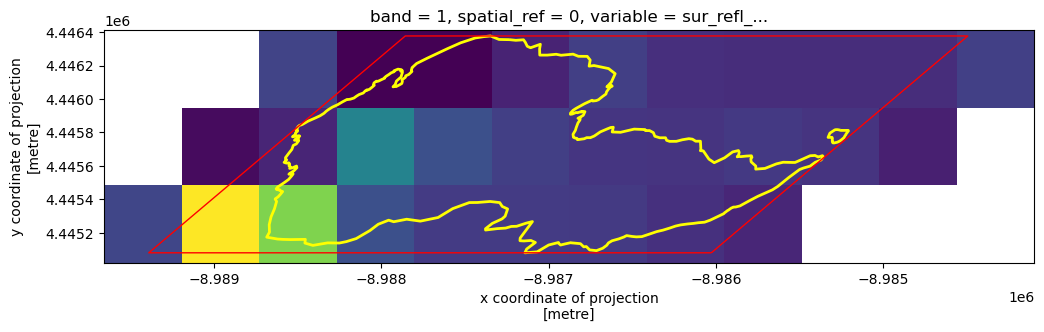

In [20]:
# Open  and
modis_crop_box = [box(*fire_boundary.total_bounds)]
modis_band = rxr.open_rasterio(modis_h4_path,
                               masked=True,
                               variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box,
                                                                     crs=fire_boundary.crs,
                                                                     all_touched=True,
                                                                     from_disk=True).squeeze()

modis_band_arr = modis_band.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_transformed_bounds.plot(ax=ax,
                              facecolor="none",
                              edgecolor="red",
                              linewidth=1)

plt.show()

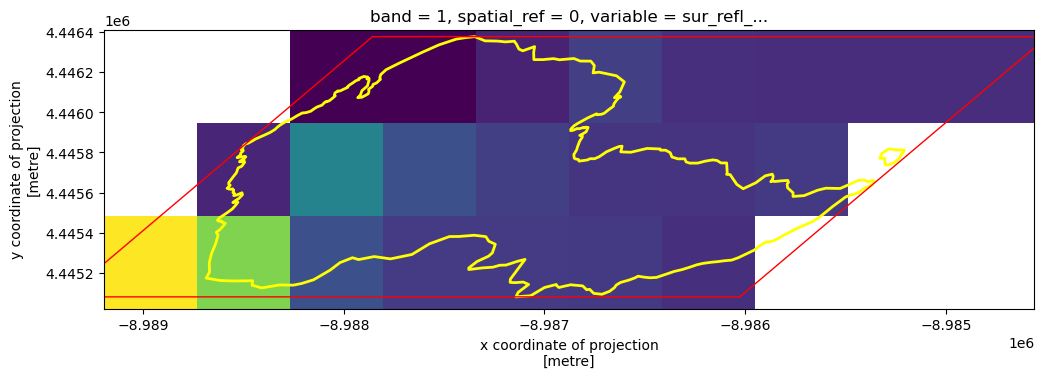

In [21]:
modis_band_1 = rxr.open_rasterio(modis_h4_path,
                                 masked=True,
                                 variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box,
                                                                       crs=fire_boundary.crs,
                                                                       all_touched=False,
                                                                       from_disk=True).squeeze()

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_transformed_bounds.plot(ax=ax,
                              facecolor="none",
                              edgecolor="red",
                              linewidth=1)

plt.show()

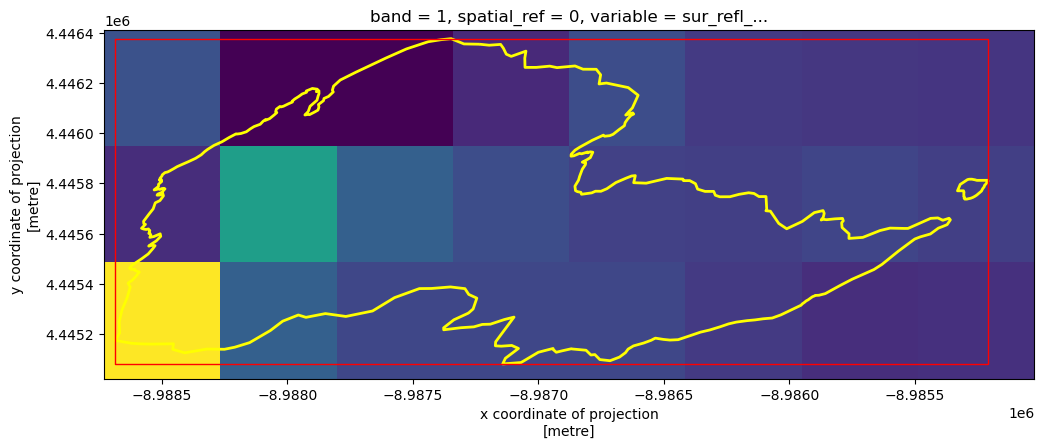

In [22]:
# reprojected box

modis_crop_box_reproj = [box(*fire_boundary_modis.total_bounds)]

modis_band_1 = rxr.open_rasterio(modis_h4_path,
                                 masked=True,
                                 variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box_reproj,
                                                                       # crs=fire_boundary.crs,
                                                                       all_touched=True,
                                                                       from_disk=True).squeeze()

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_box.plot(ax=ax,
               facecolor="none",
               edgecolor="red",
               linewidth=1)

plt.show()

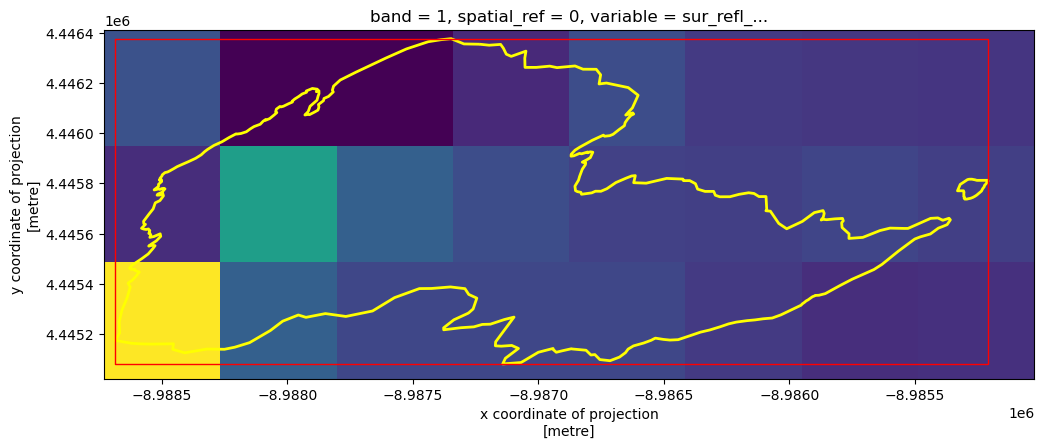

In [23]:
# reprojected box

modis_crop_box_reproj = [box(*fire_boundary_modis.total_bounds)]

modis_band_1 = rxr.open_rasterio(modis_h4_path,
                                 masked=True,
                                 variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box_reproj,
                                                                       # crs=fire_boundary.crs,
                                                                       all_touched=False,
                                                                       from_disk=True).squeeze()

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_box.plot(ax=ax,
               facecolor="none",
               edgecolor="red",
               linewidth=1)

plt.show()

### Conclusions  -  MODIS  Data  Processing

Much like Landsat, it is cleaner reproject the fire boundary first for MODIS. 



##  What about clipping with the geometry directly?

We have been clipping with a bounding box instead of complex geometry.

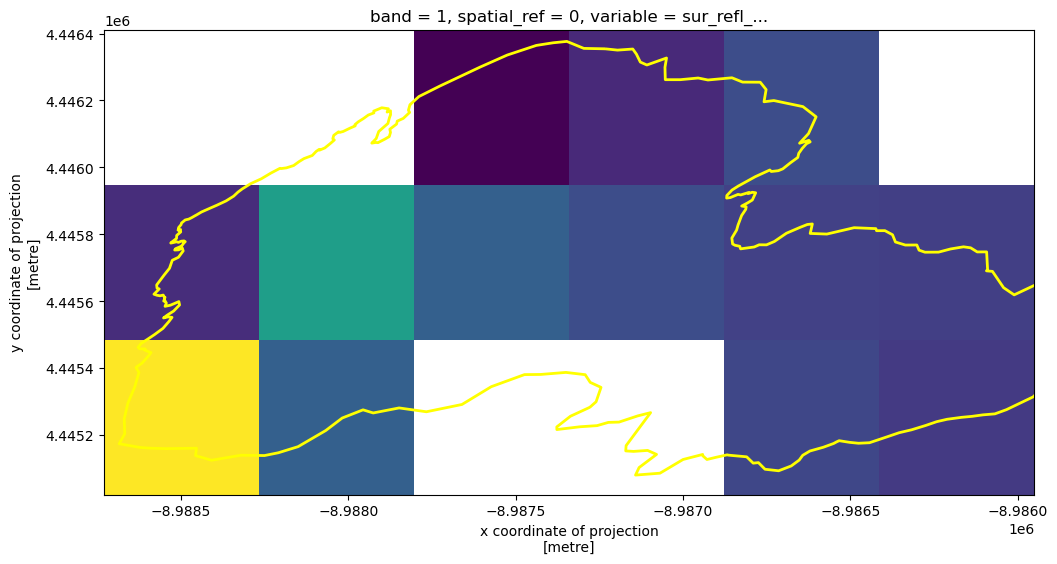

In [24]:
# Crop using the geometry rather than the bounding box

modis_band_1 = (
    rxr.open_rasterio(
        modis_h4_path,
        masked=True,
        variable=["sur_refl_b01_1"])
    .rio.clip(
        fire_boundary_modis.geometry.apply(mapping),
        all_touched=False,
        from_disk=True)
    .squeeze()
)

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(
    ax=ax,
    add_colorbar=False)
fire_boundary_modis.plot(
    ax=ax,
    facecolor="none",
    edgecolor="yellow",
    linewidth=2)

plt.show()